In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (roc_auc_score, precision_recall_curve,
                             confusion_matrix, classification_report,
                             average_precision_score)
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
orderbook = pd.read_csv("AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
print("orderbook rows:", len(orderbook))

ask_p_cols = [4*i     for i in range(10)]
ask_v_cols = [4*i + 1 for i in range(10)]
bid_p_cols = [4*i + 2 for i in range(10)]
bid_v_cols = [4*i + 3 for i in range(10)]

orderbook rows: 269748


In [3]:
def stationarise(df):
    ask_p = df[ask_p_cols].values.astype(np.float64)
    bid_p = df[bid_p_cols].values.astype(np.float64)
    ask_v = df[ask_v_cols].values.astype(np.float64)
    bid_v = df[bid_v_cols].values.astype(np.float64)

    mid    = 0.5*(ask_p[:,0] + bid_p[:,0])
    spread = np.maximum(ask_p[:,0] - bid_p[:,0], 1e-6)

    rel_ask_p = (ask_p - mid[:,None]) / spread[:,None]
    rel_bid_p = (bid_p - mid[:,None]) / spread[:,None]
    log_ask_v = np.log1p(ask_v)
    log_bid_v = np.log1p(bid_v)

    X = np.concatenate([rel_ask_p, log_ask_v, rel_bid_p, log_bid_v], axis=1)
    return X, mid, spread

X_raw, mid_raw, spread_raw = stationarise(orderbook)

In [4]:
window = 50  # past ticks
horizon = 10  # ticks ahead
stride = 10  # step between windows
theta = 0.15 # spread based threshold to classify only significant drops as a drop
val_frac = 0.10
test_frac = 0.10
batch_size = 256
num_workers = 0

In [5]:
future_mid = pd.Series(mid_raw).shift(-horizon).to_numpy()
valid = len(mid_raw)-horizon
mid_now = mid_raw[:valid]
future_mid = future_mid[:valid]
spread_now = spread_raw[:valid]
X_raw = X_raw[:valid]
ret = (future_mid - mid_now)/np.maximum(spread_now, 1e-6)
y_bin = (ret < -theta).astype(np.int64)   # 1 = actionable drop, means the drop has to be at least theta % of the spread
print("Positives ratio:", y_bin.mean())

Positives ratio: 0.08124179759618592


In [6]:
N = len(X_raw)
cut_test = int(test_frac*N)
cut_val = int(val_frac*N)
train_slice = slice(0, N-cut_val-cut_test)
val_slice = slice(N-cut_val-cut_test, N-cut_test)
test_slice = slice(N-cut_test, N)

X_train_raw, y_train_raw = X_raw[train_slice], y_bin[train_slice]
X_val_raw, y_val_raw = X_raw[val_slice], y_bin[val_slice]
X_test_raw, y_test_raw = X_raw[test_slice], y_bin[test_slice]

In [7]:
def seq_builder(X, y, w=window, s=stride):
    Xs, ys = [], []
    for i in range(0, len(X)-w+1, s):
        Xs.append(X[i:i+w]); ys.append(y[i+w-1])
    return np.asarray(Xs, np.float32), np.asarray(ys, np.int64)

X_tr, y_tr = seq_builder(X_train_raw, y_train_raw)
X_va, y_va = seq_builder(X_val_raw,   y_val_raw)
X_te, y_te = seq_builder(X_test_raw,  y_test_raw)
print("Sequences shapes:", X_tr.shape, X_va.shape, X_te.shape)

Sequences shapes: (21575, 50, 40) (2693, 50, 40) (2693, 50, 40)


In [8]:
scaler = StandardScaler()
scaler.fit(X_tr.reshape(-1, X_tr.shape[-1]))
scale = lambda x: scaler.transform(x.reshape(-1,x.shape[-1])).reshape(x.shape)
X_tr, X_va, X_te = map(scale, (X_tr, X_va, X_te))

In [9]:
class LOBinDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).permute(0,2,1)
        self.y = torch.tensor(y).float().unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i]

train_loader = DataLoader(LOBinDS(X_tr, y_tr), batch_size=256, shuffle=True, num_workers=0)
val_loader   = DataLoader(LOBinDS(X_va, y_va), batch_size=256, shuffle=False)
test_loader  = DataLoader(LOBinDS(X_te, y_te), batch_size=256, shuffle=False)

In [10]:
class CNN_LSTM_BIN(nn.Module):
    def __init__(self, feat_in, T=window):
        super().__init__()
        self.conv1 = nn.Conv1d(feat_in, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3   = nn.BatchNorm1d(256)
        self.pool  = nn.MaxPool1d(2)
        self.drop  = nn.Dropout(0.3)

        with torch.no_grad():
            d = torch.zeros(1, feat_in, T)
            x = self.pool(F.relu(self.bn1(self.conv1(d))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            t_after, c_after = x.shape[-1], x.shape[1]
        self.lstm = nn.LSTM(c_after, 128, batch_first=True, bidirectional=True)
        self.fc1  = nn.Linear(128*2, 64)
        self.fc2  = nn.Linear(64, 1)

    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))); x=self.drop(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x)))); x=self.drop(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x)))); x=self.drop(x)
        x = x.permute(0,2,1)
        out,_ = self.lstm(x)
        x = out.mean(dim=1)
        x = F.relu(self.fc1(x)); x=self.drop(x)
        return self.fc2(x)

model = CNN_LSTM_BIN(X_tr.shape[2]).to(device)

In [11]:
neg, pos = np.bincount(y_tr)
pos_weight = torch.tensor([(neg/pos)**0.5], device=device)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer  = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                       factor=0.5, patience=3, min_lr=1e-6)

In [12]:
epochs = 100
train_l, val_l = [], []
for ep in range(1,epochs+1):
    model.train(); run=0.
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(); loss = criterion(model(xb), yb); loss.backward(); optimizer.step(); run+=loss.item()
    tl = run/len(train_loader); train_l.append(tl)

    model.eval(); vrun=0.
    with torch.no_grad():
        for xb,yb in val_loader:
            vrun += criterion(model(xb.to(device)), yb.to(device)).item()
    vl = vrun/len(val_loader); val_l.append(vl); scheduler.step(vl)
    print(f"Ep {ep:3d} | train {tl:.4f} | val {vl:.4f} | lr {optimizer.param_groups[0]['lr']:.2e}")

Ep   1 | train 0.6436 | val 0.5777 | lr 3.00e-04
Ep   2 | train 0.6087 | val 0.5652 | lr 3.00e-04
Ep   3 | train 0.5951 | val 0.5572 | lr 3.00e-04
Ep   4 | train 0.5820 | val 0.5508 | lr 3.00e-04
Ep   5 | train 0.5751 | val 0.5433 | lr 3.00e-04
Ep   6 | train 0.5687 | val 0.5500 | lr 3.00e-04
Ep   7 | train 0.5619 | val 0.5446 | lr 3.00e-04
Ep   8 | train 0.5540 | val 0.5476 | lr 3.00e-04
Ep   9 | train 0.5535 | val 0.5421 | lr 3.00e-04
Ep  10 | train 0.5517 | val 0.5425 | lr 3.00e-04
Ep  11 | train 0.5505 | val 0.5400 | lr 3.00e-04
Ep  12 | train 0.5444 | val 0.5357 | lr 3.00e-04
Ep  13 | train 0.5413 | val 0.5386 | lr 3.00e-04
Ep  14 | train 0.5430 | val 0.5385 | lr 3.00e-04
Ep  15 | train 0.5428 | val 0.5394 | lr 3.00e-04
Ep  16 | train 0.5380 | val 0.5437 | lr 1.50e-04
Ep  17 | train 0.5234 | val 0.5455 | lr 1.50e-04
Ep  18 | train 0.5209 | val 0.5446 | lr 1.50e-04
Ep  19 | train 0.5228 | val 0.5483 | lr 1.50e-04
Ep  20 | train 0.5218 | val 0.5507 | lr 7.50e-05
Ep  21 | train 0.517

In [13]:
r_min = 0.60 # minimum recall wanted
p_min = 0.30 # minimum precision wanted
gain_right = 1.0 # unit gain per caught down move (scaled)
cost_wrong = 0.5 # unit cost per wrong short

In [14]:
model.eval(); probs, ytrue = [], []
with torch.no_grad():
    for xb,yb in test_loader:
        logits = model(xb.to(device)); probs.append(torch.sigmoid(logits).cpu()); ytrue.append(yb)
probs = torch.cat(probs).numpy().ravel(); ytrue = torch.cat(ytrue).numpy().ravel()

roc = roc_auc_score(ytrue, probs)
pr_auc = average_precision_score(ytrue, probs)
print(f"ROC‑AUC {roc:.3f} | PR‑AUC {pr_auc:.3f}")

prec, rec, thr = precision_recall_curve(ytrue, probs)
prec_t, rec_t, thr = prec[1:], rec[1:], thr  # align
mask = (rec_t>=r_min) & (prec_t>=p_min)
if mask.any():
    chosen = thr[mask][0]; reason='constraint'
else:
    mask_r = rec_t>=r_min
    if mask_r.any():
        idx = np.argmax(prec_t[mask_r]); chosen = thr[mask_r][idx]; reason='recall-max-prec'
    else:
        ev = rec_t*gain_right - (1-prec_t)*cost_wrong; chosen = thr[np.argmax(ev)]; reason='ev'
print(f"Chosen thr ({reason}) = {chosen:.3f}")

ROC‑AUC 0.647 | PR‑AUC 0.218
Chosen thr (recall-max-prec) = 0.200


In [15]:
preds = (probs > chosen).astype(int)
print("Confusion matrix:\n", confusion_matrix(ytrue, preds))
print(classification_report(ytrue, preds, digits=3))

Confusion matrix:
 [[1508  892]
 [ 113  180]]
              precision    recall  f1-score   support

         0.0      0.930     0.628     0.750      2400
         1.0      0.168     0.614     0.264       293

    accuracy                          0.627      2693
   macro avg      0.549     0.621     0.507      2693
weighted avg      0.847     0.627     0.697      2693



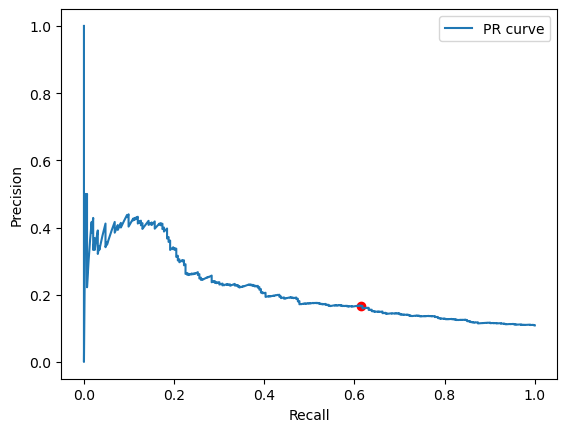

In [16]:
plt.figure(); plt.plot(rec_t, prec_t, label='PR curve');
idx = np.argmin(np.abs(thr-chosen)); plt.scatter(rec_t[idx], prec_t[idx], c='red');
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()